In [76]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

DEFAULT_SEED = 42

from gaussian import MultivariateNormal, DynamicMultivariateNormal, VarianceExploding, VariancePreserving, SubVariancePreserving

In [102]:
def cube_vertices(dim, side_len=1.0, var=1e-2):
    vertices1d = np.array([0.0, side_len])
    all_vertices1d = vertices1d.reshape(1, 2).repeat(dim, axis=0)
    all_vertices = np.meshgrid(*all_vertices1d)
    vertices = np.stack(all_vertices, axis=-1).reshape(-1, dim)
    var = var * np.eye(dim)
    return [DynamicMultivariateNormal(dim, vertex, var) for vertex in vertices]

In [103]:
def simulate_sde(
    mix, tf=1.0, nt=50_000, num_save=200, num_sample=2000, seed=DEFAULT_SEED
):
    x_init = mix.sample(num_sample, seed=seed)
    dt = tf / nt
    t = np.linspace(0.0, tf, nt + 1)

    save_every = nt // num_save
    x = x_init[:, None, :].repeat(num_save + 1, 1)

    rng = np.random.default_rng(seed)

    x_cur = x_init
    for i in range(1, nt + 1):
        t_cur = t[i - 1]
        dw = np.sqrt(dt) * rng.normal(size=x_cur.shape)
        x_cur = x_cur + dt * mix.f(t_cur, x_cur) + mix.g(t_cur) * dw
        if i % save_every == 0:
            x[:, i // save_every, :] = x_cur

    return t[::save_every], x


def simulate_ode(
    mix, n_sample=5_000, num_save=200, t_min=1e-6, tf=1.0, seed=DEFAULT_SEED
):
    def flat_ode(t, x_flat):
        x = x_flat.reshape(-1, mix.dim)
        return mix.ode(t, x).flatten()

    x_init = mix.sample(n_sample, seed=seed)

    solve_params = dict(
        rtol=1e-10, atol=1e-10, t_eval=np.linspace(t_min, tf, num_save + 1)
    )
    sol = solve_ivp(flat_ode, (t_min, tf), x_init.flatten(), **solve_params)
    x = sol.y.reshape(n_sample, mix.dim, num_save + 1).transpose(0, 2, 1)
    return sol.t, x

## Square (2D)

In [104]:
def plot2d(mix, t, x, show_every=50):
    num_plots = (len(t) - 1) // show_every + 1
    fig, ax = plt.subplots(1, num_plots, figsize=(15, 3))

    for i in range(num_plots):
        si = i * show_every
        ti = t[si]
        xi = x[:, si, :]
        ax[i].scatter(*xi.T, s=1)

        x_min, x_max = xi.min(0), xi.max(0)
        x_range = x_max - x_min
        x_min, x_max = x_min - 0.15 * x_range, x_max + 0.15 * x_range

        x_cont_flat = np.linspace(x_min, x_max, 200)
        x_cont = np.stack(np.meshgrid(*x_cont_flat.T), -1)
        log_dens = mix.density(ti, x_cont)

        x1_cont, x2_cont = x_cont[:, :, 0], x_cont[:, :, 1]
        ax[i].contour(x1_cont, x2_cont, log_dens, levels=10, alpha=0.5, cmap="plasma")

        x_quiv_flat = x_cont_flat[5::10]
        x_quiv = np.stack(np.meshgrid(*x_quiv_flat.T), -1)
        score, div_score = mix.score_with_div(ti, x_quiv)

        x1_quiv, x2_quiv = x_quiv[:, :, 0], x_quiv[:, :, 1]
        score1, score2 = score[:, :, 0], score[:, :, 1]
        ax[i].quiver(x1_quiv, x2_quiv, score1, score2, div_score, alpha=1.0)
    return fig, ax

### Variance exploding

In [105]:
mix2d = VarianceExploding(cube_vertices(2))
tf = 40.0
prior2d = MultivariateNormal(mix2d.dim, cov=mix2d.added_noise_sq(tf) * np.eye(mix2d.dim))
t_sde, x_sde = simulate_sde(mix2d, tf=tf)
t_ode, x_ode = simulate_ode(mix2d, tf=tf)

#### Noising

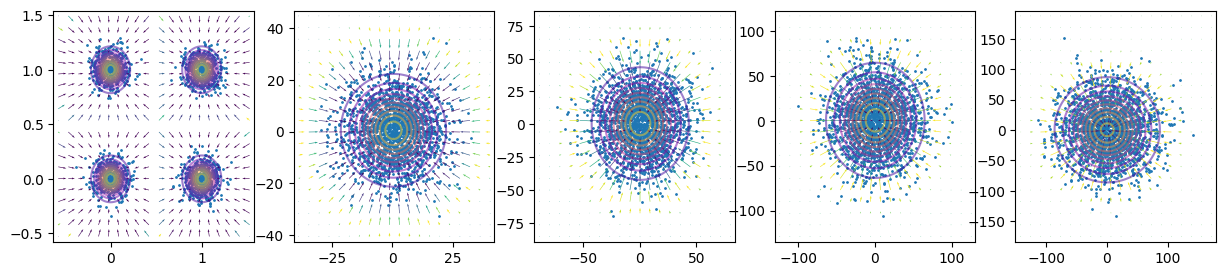

In [106]:
fig, ax = plot2d(mix2d, t_sde, x_sde)

#### Pseudo-noising (with the ODE)

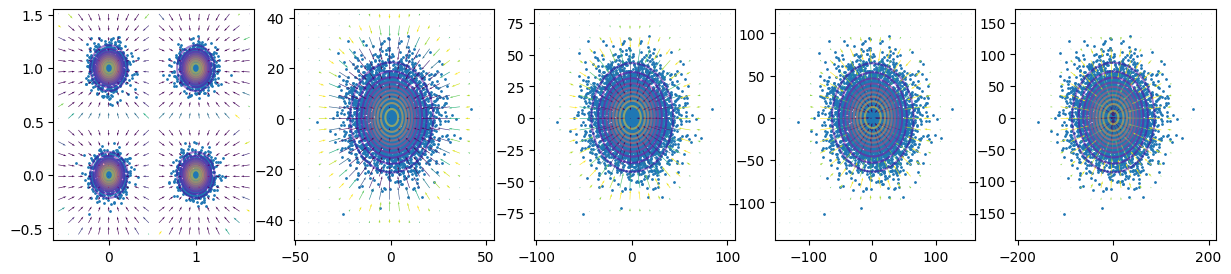

In [107]:
fig, ax = plot2d(mix2d, t_ode, x_ode)

### Variance-preserving

In [108]:
mix2d = VariancePreserving(cube_vertices(2))
prior2d = MultivariateNormal(mix2d.dim)
t_sde, x_sde = simulate_sde(mix2d)
t_ode, x_ode = simulate_ode(mix2d)

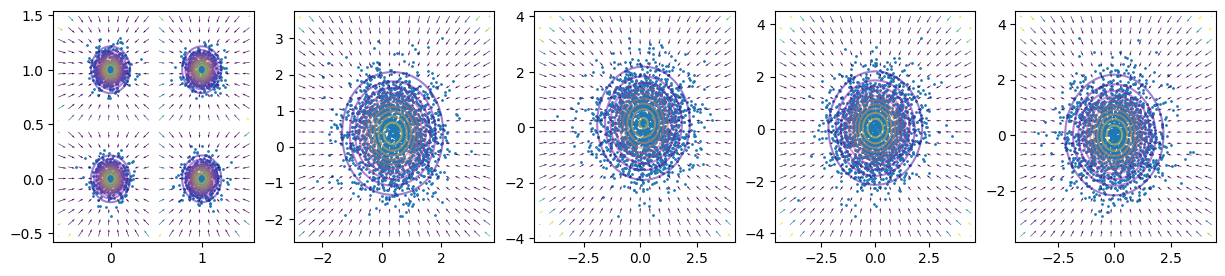

In [109]:
fig, ax = plot2d(mix2d, t_sde, x_sde)

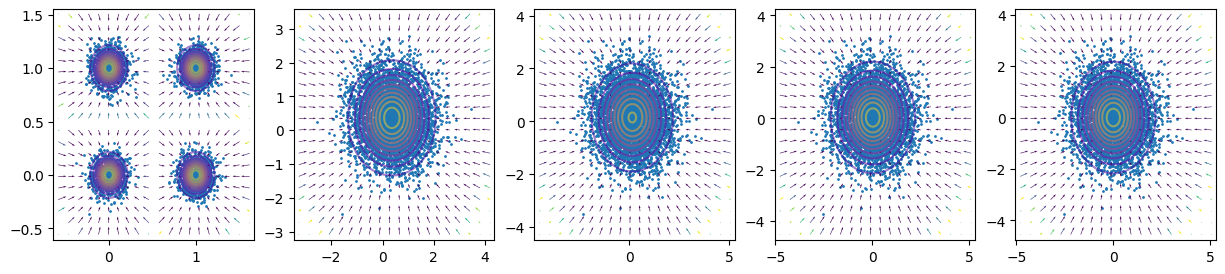

In [110]:
fig, ax = plot2d(mix2d, t_ode, x_ode)

### Compare clustering (VP-case)

In [111]:
def plot2d_clusters(t, x, show_every=50, side_len=1.0):
    num_plots = (len(t) - 1) // show_every + 1
    fig, ax = plt.subplots(1, num_plots, figsize=(15, 3))

    right = x[:, 0, 0] > 0.5 * side_len
    upper = x[:, 0, 1] > 0.5 * side_len
    cmap = mpl.color_sequences["tab10"]
    colors = np.empty((len(x), 3))
    colors[right & upper] = cmap[0]
    colors[right & ~upper] = cmap[1]
    colors[~right & upper] = cmap[2]
    colors[~right & ~upper] = cmap[3]

    for i in range(num_plots):
        si = i * show_every
        xi = x[:, si, :]
        ax[i].scatter(*xi.T, s=1, c=colors)

    return fig, ax

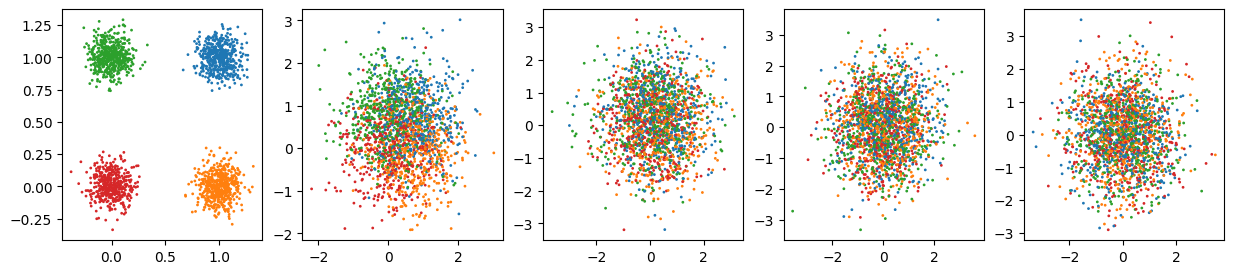

In [112]:
fig, ax = plot2d_clusters(t_sde, x_sde)

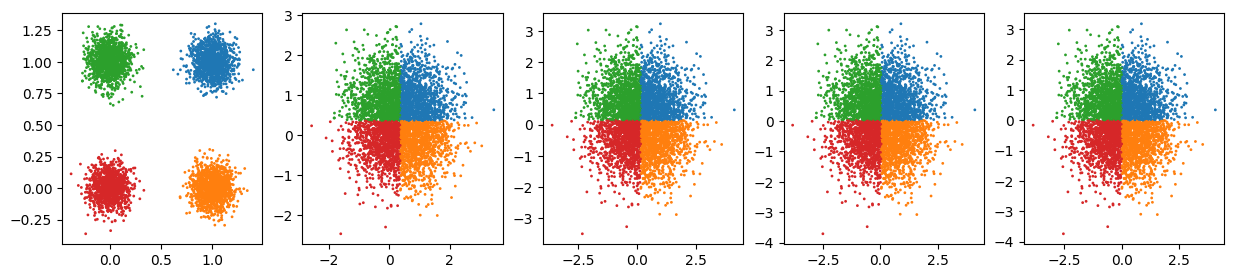

In [113]:
fig, ax = plot2d_clusters(t_ode, x_ode)

## Cube (3D)

In [114]:
def plot3d(mix, t, x, show_indices=None):
    fig = plt.figure(figsize=(15, 3))

    if show_indices is None:
        show_indices = range(0, len(t) + 1, len(t) // 5)
    for i, si in enumerate(show_indices):
        ax = fig.add_subplot(1, len(show_indices), i + 1, projection="3d")
        ti = t[si]
        xi = x[:, si, :]

        div_score = mix.score_with_div(ti, xi)[1][..., 0]
        norm_col = mpl.colors.Normalize(div_score.min(), div_score.max())
        colors = mpl.colormaps["plasma"](norm_col(div_score))

        ax.scatter(*xi.T, s=1, c=colors, alpha=0.5)
        ax.set_title(f"t = {ti:.2f}")
    
    return fig

### Variance exploding

In [115]:
mix3d = VarianceExploding(cube_vertices(3))
tf = 40.0
show_indices = [0, 2, 5, 10, -1]
t_sde, x_sde = simulate_sde(mix3d, tf=tf)
t_ode, x_ode = simulate_ode(mix3d, tf=tf)

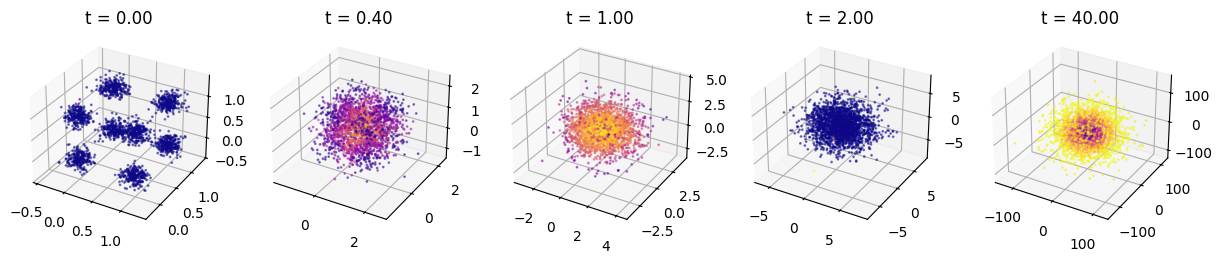

In [116]:
plot3d(mix3d, t_sde, x_sde, show_indices=show_indices);

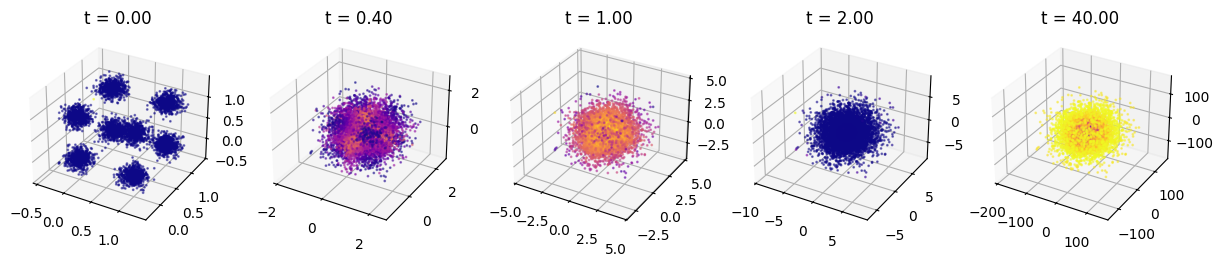

In [117]:
plot3d(mix3d, t_ode, x_ode, show_indices=show_indices);

### Variance preserving

In [118]:
mix3d = VariancePreserving(cube_vertices(3))
show_indices = [0, 2, 5, 10, -1]
t_sde, x_sde = simulate_sde(mix3d)
t_ode, x_ode = simulate_ode(mix3d)

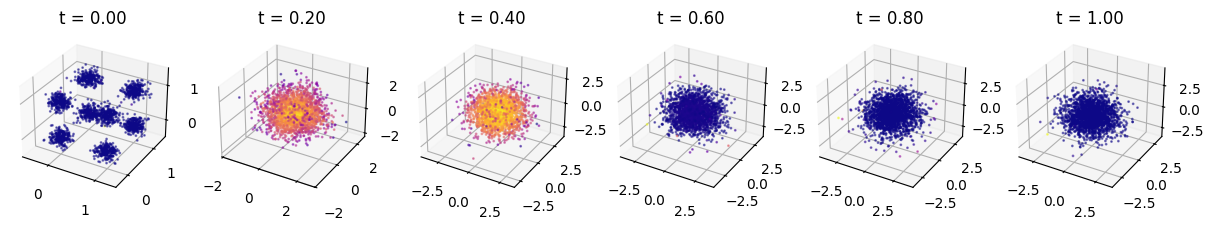

In [119]:
plot3d(mix3d, t_sde, x_sde);

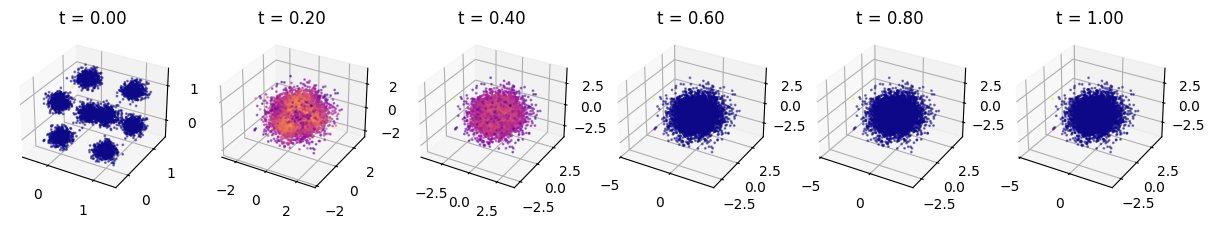

In [120]:
plot3d(mix3d, t_ode, x_ode);